# Project: Investigate a Dataset - [The Movie Database]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> This data set contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue.

Let's have a look at what we got...

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns # I know I will be using a heatmap to start my exploration
import matplotlib.pyplot as plt

# load dataset
df = pd.read_csv('Database_TMDb_movie_data/tmdb-movies.csv')

df.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

After a quick look at our dataset, we can see that:
   - We have 21 columns and 10866 rows
   - We have two forms of ID, one is probably sufficient so we will drop one of them
   - We also have two sets of budget and revenue columns. We will probably just stick with one set, most likely the one adjusted for inflation so we can better compare failure and success of movies
   - Most of our data seems well cleaned, with votes, years, runtime, popularity as integers and floats, and strings represented as strings
   - It also looks like they filled in some columns - cast, genre, and production company - with mulitiple values separated by the pipe '|'


### Question(s) for Analysis
There are quite a few questions that come up, but here is one that will get us started in the right direction, and may answer the question most production companies will want to know:
 
 - What variables influence revenue?

    - Dependent variable: revenue_adj

    - Independent variables: budget_adj, genres, director, popularity


<a id='wrangling'></a>
## Data Wrangling

> Let's get our data into shape


### Data Cleaning

In [15]:
# First things first, let's drop those unecessary columns we mentioned before
df.drop(columns=['imdb_id', 'budget', 'revenue'], inplace=True)

In [16]:
# Next, there is one data type I think we should change:
# release_year is an integer, and that may be fine, 
# but release_date is a string, and pandas has a to_dateteime method, 
# so let's take advantage of that
df['release_date'] = pd.to_datetime(df['release_date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    10866 non-null  int64         
 1   popularity            10866 non-null  float64       
 2   original_title        10866 non-null  object        
 3   cast                  10790 non-null  object        
 4   homepage              2936 non-null   object        
 5   director              10822 non-null  object        
 6   tagline               8042 non-null   object        
 7   keywords              9373 non-null   object        
 8   overview              10862 non-null  object        
 9   runtime               10866 non-null  int64         
 10  genres                10843 non-null  object        
 11  production_companies  9836 non-null   object        
 12  release_date          10866 non-null  datetime64[ns]
 13  vote_count      

In [3]:
# One more thing I would like to do is break up those big 'objects' into a list of distint strings
# Given there are only three columns with pipes, we could just write 3 lines of code,
# but let's create a function to do the job for us
def pipe_split(df, columns):
    for col in columns:
        df[col] = df[col].astype(str).str.split('|')
        
    return df
    # Isn't that pretty?

df = pipe_split(df, ['cast', 'genres', 'production_companies'])

df.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,"[Action, Adventure, Science Fiction, Thriller]","[Universal Studios, Amblin Entertainment, Lege...",6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,"[Action, Adventure, Science Fiction, Thriller]","[Village Roadshow Pictures, Kennedy Miller Pro...",5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,"[Shailene Woodley, Theo James, Kate Winslet, A...",http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,"[Adventure, Science Fiction, Thriller]","[Summit Entertainment, Mandeville Films, Red W...",3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08


In [4]:
# We've trimmed up our data, 
# now let's see if we need to fatten it up at all or drop more
df.isna().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                       0
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                     0
production_companies       0
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [5]:
# websites, taglines, and keywords probably play a big role in marketing, 
# but considering how much is missing here,
# and since we have other variables to work with,
# let's go ahead drop those columns

df.drop(columns=['homepage', 'tagline', 'keywords'], inplace=True)

In [6]:
# truthfully, overview is just text and not really gonna help us
# let's drop that too

df.drop(columns=['overview'], inplace=True)

In [7]:
# our directors may be important though
# and with only 44 missing we should definitely keep them in
# since we aren't dealing with numbers here,
# I don't like the idea of filling in the data with the most common (or average - as if that was possible) director
# and dropping the whole row because of one missing value seems wasteful
# so let's just put in 'Unknown'

df['director'] = df['director'].fillna('Unkown')

In [8]:
df.isna().sum()

id                       0
imdb_id                 10
popularity               0
budget                   0
revenue                  0
original_title           0
cast                     0
director                 0
runtime                  0
genres                   0
production_companies     0
release_date             0
vote_count               0
vote_average             0
release_year             0
budget_adj               0
revenue_adj              0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10866 non-null  object 
 7   director              10866 non-null  object 
 8   runtime               10866 non-null  int64  
 9   genres                10866 non-null  object 
 10  production_companies  10866 non-null  object 
 11  release_date          10866 non-null  object 
 12  vote_count            10866 non-null  int64  
 13  vote_average          10866 non-null  float64
 14  release_year          10866 non-null  int64  
 15  budget_adj         

<a id='eda'></a>
## Exploratory Data Analysis

> Let's explore our data in an analytical way.


### What variables most affect movie revenue?

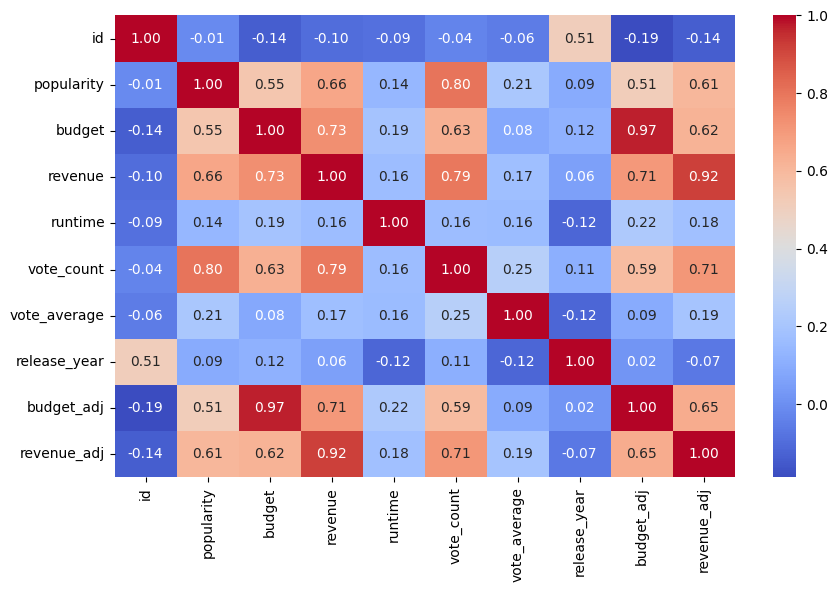

In [10]:
# I like to start with heat map to get an overview of possible correlations
# So, let's start by putting our numerical columns together
num_cols = df.select_dtypes(include=['float64', 'int64'])

# create the matrix
corr = num_cols.corr()

# putting together the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f') # shows us the values from our matrix, to two decimal places,and with blue and red colors
plt.show()

### Correlation Analysis
There's more blue than red, which means we don't have too many correlations (with our numerical values). Let's look at revenue:
 - **popularity: 0.61** - a decent correlation but perhaps not as strong as one would imagine
 - runtime: 0.18 - a weak correlation between runtime and revenue
 - **vote_count: 0.71** - our strongest correlation to revenue is how many people voted for it. Probably the connecting aspect here is just how known the movie is. More people saw it, paid to see it, and voted for it (good or bad).
 - vote_average: 0.19 - It doesn't have to be a good movie to make money it seems
 - releaase_year: -0.07 - Has almost literally no affect, good or bad, on the revenue
 - **budget: 0.65** - There is a positive correlation between how much the movie cost to make and how much it made, but perhaps not as strong as many companies would hope.
 
 The strongest correlation on the entire map is between vote_count and popularity.

<AxesSubplot: xlabel='genres'>

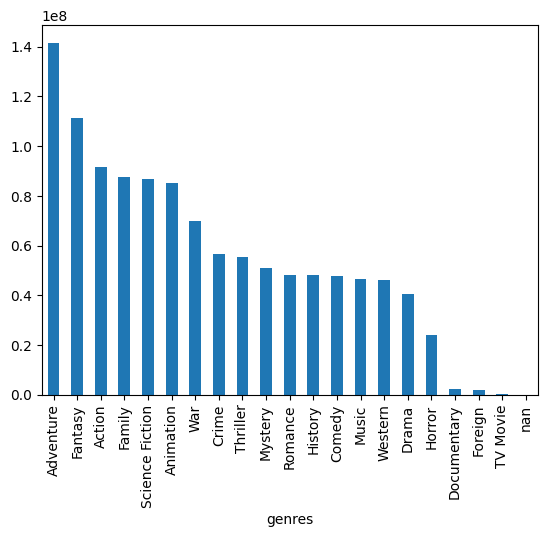

In [11]:
# Now let's look at the genres
df_genres = df.explode('genres') # breaking up ('exploding') our list of genres into rows

# genre and average revenue
genre_revenue = df_genres.groupby('genres')['revenue_adj'].mean().sort_values(ascending=False) 

# the plot, we'll use pandas this time
genre_revenue.plot.bar(x='genres', y='revenue_adj')

### And we have a clear winner
***Adventure*** films clearly bring in more revenue with an average: $140,000,000

A distinct second place goes to Fantasy, followed by Action, Family, Science Fiction, and Animation.

Documentaries and Foreign films make very little, but much like TV movies, they probably don't actually make it on the big screen very often.

In [12]:
# Let's move to directors now
directors = df['director'].value_counts()

directors

Woody Allen                 45
Unkown                      44
Clint Eastwood              34
Martin Scorsese             29
Steven Spielberg            29
                            ..
Jeffrey Porter               1
Larry Shaw                   1
Bill Pohlad                  1
Andy Hamilton|Guy Jenkin     1
Harold P. Warren             1
Name: director, Length: 5068, dtype: int64

<AxesSubplot: xlabel='director'>

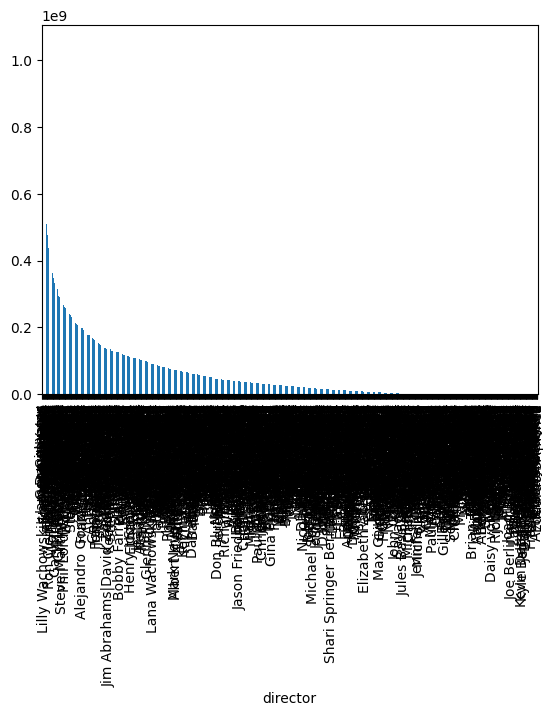

In [13]:
# We've got over 5000 directors in dataset of 10000 movies.
# Let's be a bit selective and only look at directors with 3 or movies
directors_3 = directors[directors >= 3].index # we only want a list of the directors' names
df_directors = df[df['director'].isin(directors_3)]

director_revenue = df_directors.groupby('director')['revenue_adj'].mean().sort_values(ascending=False)

director_revenue.plot.bar(x='director', y='revenue_adj')

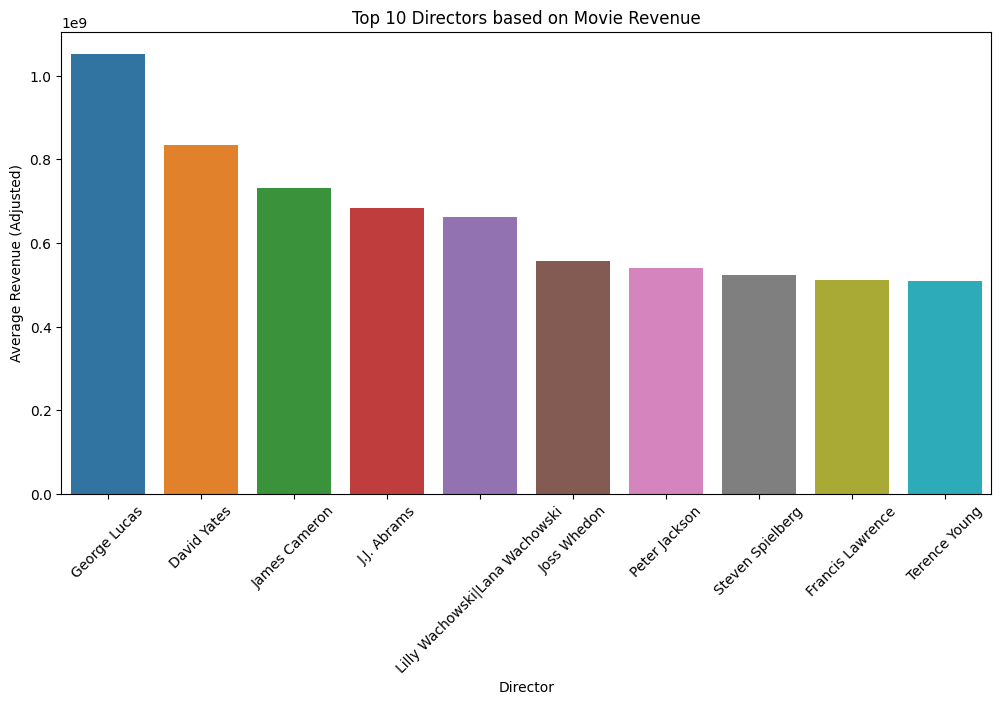

In [14]:
# Well, there's definitely some directors that make more bank than others
# But who can tell with this barplot?
# Let's whittle down the directors to the top 10
top_10_directors = df_directors.groupby('director')['revenue_adj'].mean().sort_values(ascending=False).head(10)

# and let's use matplotlib and seaborn for our plotting
plt.figure(figsize=(12, 6)) # the size of our box
sns.barplot(x=top_10_directors.index, y=top_10_directors.values) # the data for our plot

# Making the box pretty
plt.title('Top 10 Directors based on Movie Revenue')
plt.ylabel('Average Revenue (Adjusted)')
plt.xlabel('Director')
plt.xticks(rotation=45) # this puts our director names at an angle so they don't write over each other
plt.show()

### Stars Wars, Anybody?
**George Lucas** is our most profitable director (on average per film) at over a billion dollars.

### Not quite satisfied, yet
We could make a quick conclusion that says 'Go buy George Lucas and the Star Wars series'. But I think we've seen that Disney already did that and squezed every penny out of the idea.

Let's dig a little more, shall we?

<AxesSubplot: xlabel='release_year'>

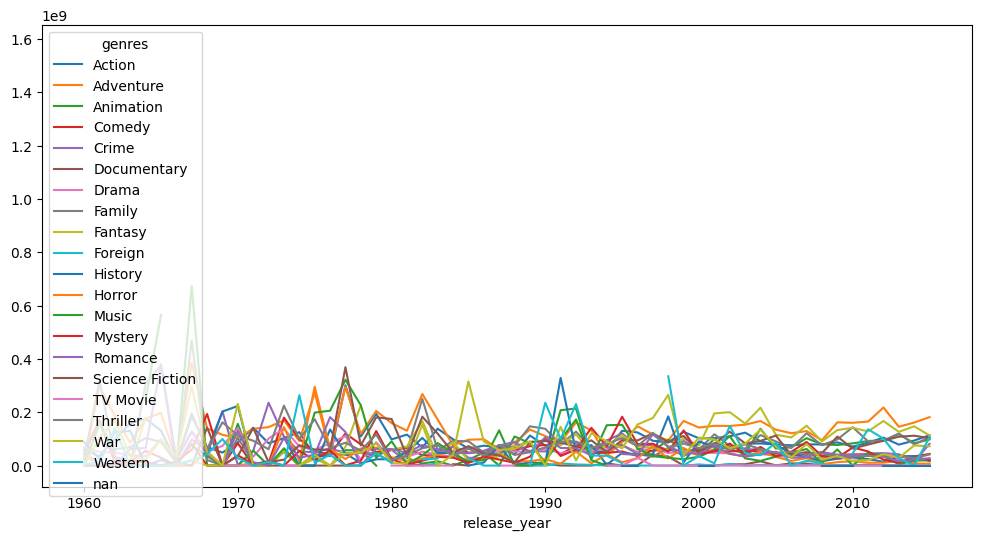

In [15]:
# Let's see how time plays a role in movie genres and revenue
genre_rev_by_year = df_genres.groupby(['release_year', 'genres'])['revenue_adj'].mean().unstack()

genre_rev_by_year.plot(figsize=(12, 6))

### Observations
> There are a lot of spikes, and I'm sure a movie buff could tell you which ones were which. It does look like Adventure rides the top of the pack for the last 20 years, but nothing really conclusive or obvious from this graph.

In [17]:
# The spikes have me thinking about outliers, 
# let's see if we can find any
# a z-score can tell us how skewed our data is
revenue_z = (df['revenue_adj'] - np.mean(df['revenue_adj'])) / np.std(df['revenue_adj'])

# we'll give this data its own column in our dataframe
df['revenue_z'] = revenue_z

outliers = df[np.abs(revenue_z) > 3] # the rule of thumb is usually +-2, but I wanna narrow down to those big spikes we saw

print(outliers[['original_title', 'revenue_adj', 'revenue_z']])

                           original_title   revenue_adj  revenue_z
0                          Jurassic World  1.392446e+09   9.272766
3            Star Wars: The Force Awakens  1.902723e+09  12.801024
4                               Furious 7  1.385749e+09   9.226460
5                            The Revenant  4.903142e+08   3.035073
7                             The Martian  5.477497e+08   3.432204
...                                   ...           ...        ...
10724     On Her Majesty's Secret Service  4.872780e+08   3.014079
10725  Butch Cassidy and the Sundance Kid  6.081511e+08   3.849843
10755                              Grease  6.077490e+08   3.847063
10756                              Jaws 2  6.280400e+08   3.987363
10758                            Superman  1.003539e+09   6.583711

[241 rows x 3 columns]


In [28]:
# Movie revenue is not a normal distribution game
# Let's break it down further
hits = df[revenue_z > 10]
flops = df[revenue_z < (-2)]
# I didn't start my z-scores at 10...

print(hits[['original_title', 'revenue_z']])

                       original_title  revenue_z
3        Star Wars: The Force Awakens  12.801024
1329                        Star Wars  18.934017
1386                           Avatar  19.192695
5231                          Titanic  16.975124
8094                          The Net  10.590675
8889       E.T. the Extra-Terrestrial  12.033327
9806                             Jaws  12.830637
10110  One Hundred and One Dalmatians  10.533736
10594                    The Exorcist  14.630585


In [29]:
# And now the flops
print(flops[['original_title', 'revenue_z']])

Empty DataFrame
Columns: [original_title, revenue_z]
Index: []


### Observations
 > It seems we only have hits and no flops. But we know that isn't possible. Our Star Wars, Avatar, and Titantic our crushing our z-scores to where there won't be a skew to the bottom of the barrel.
 
 Let's try one more thing.

In [32]:
df['roi'] = (df['revenue_adj'] - df['budget_adj']) / df['budget_adj']

# our new way to measure flops and hits
roi_hits = df[df['roi'] > 5] # made 5x their budget
roi_flops = df[df['roi'] < -0.5] # lost more than half their budget

roi_flops.shape

(1903, 19)

### There's our flops.
Almost 1 out of 5 movies 'flop' - lose more than half their budget. That must be painful.

Let's look at our hits now

<AxesSubplot: xlabel='genres'>

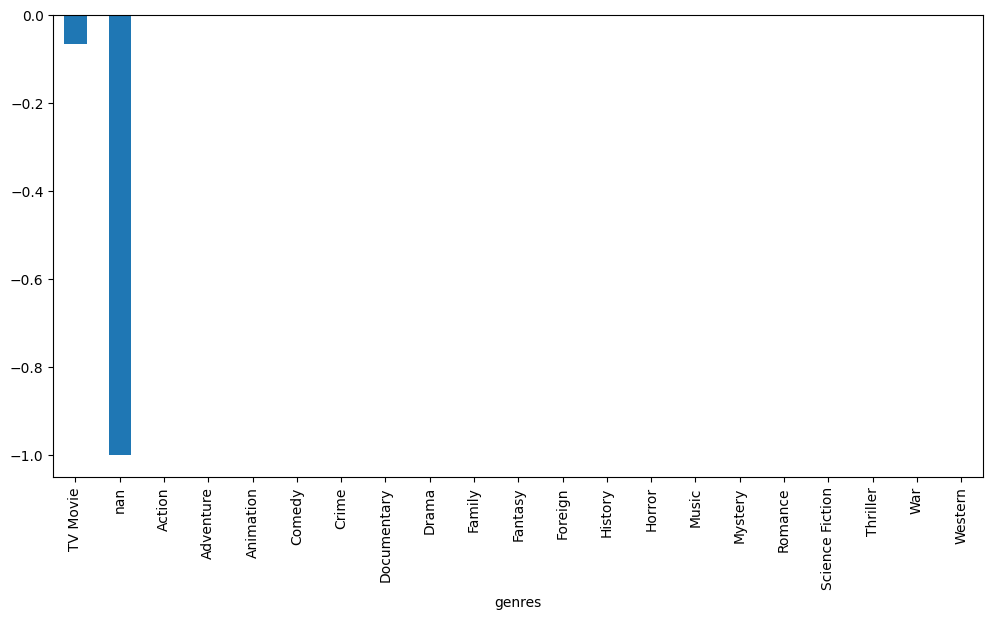

In [38]:
# so we have our dataframe of hits
# let's circle back to our big money adventure genre 
# and see if big money is the same thing as smart money
df_genres = df.explode('genres') # we have to do this again since we have added roi since our last df_genres

roi_by_genre = df_genres.groupby('genres')['roi'].mean().sort_values(ascending=False)
roi_by_genre.plot(kind='bar', figsize=(12, 6))

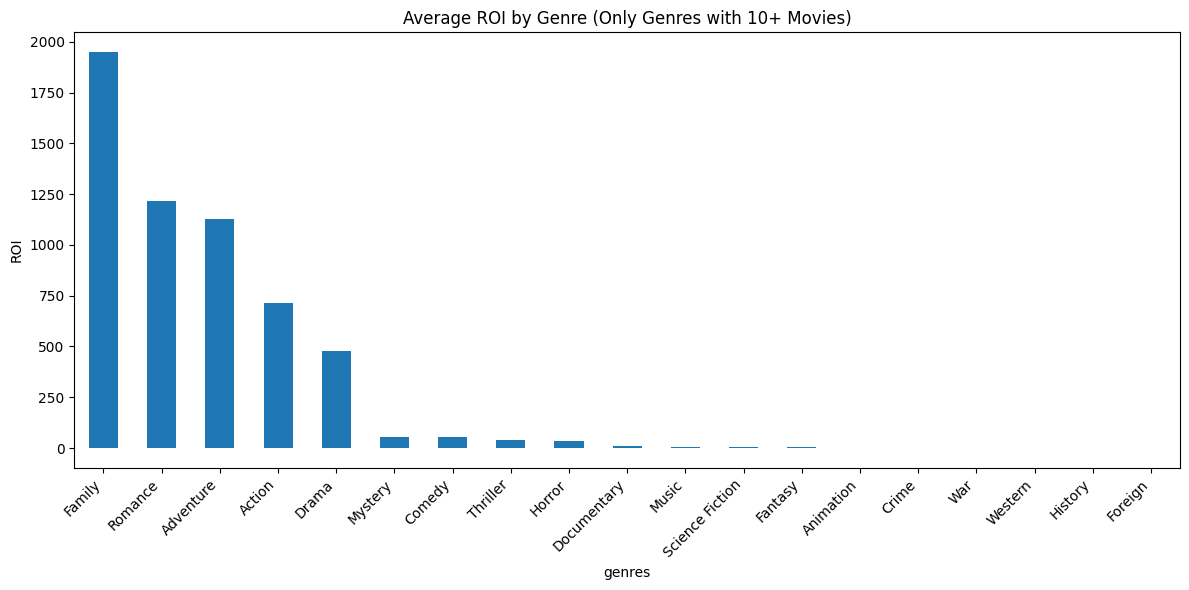

In [39]:
# I don't like that. 
# time to get serious
# last minute cleaning.

# make sure 'roi' is calculated
df['roi'] = (df['revenue_adj'] - df['budget_adj']) / df['budget_adj']
df = df.replace([np.inf, -np.inf], np.nan)  # replace infinite ROI (0 budget) with NaN
df = df.dropna(subset=['roi'])  # drop rows where roi couldn't be calculated

# boom
df_genres = df.explode('genres')

# drop those guacala NaN genres
df_genres = df_genres.dropna(subset=['genres'])

# let's focus on genres well enough established to have at least 10 films
genre_counts = df_genres['genres'].value_counts()
valid_genres = genre_counts[genre_counts >= 10].index
df_genres = df_genres[df_genres['genres'].isin(valid_genres)]

# finally, the plot
roi_by_genre = df_genres.groupby('genres')['roi'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
roi_by_genre.plot(kind='bar')
plt.title('Average ROI by Genre (Only Genres with 10+ Movies)')
plt.ylabel('ROI')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed in relation to the question(s) provided at the beginning of the analysis. Summarize the results accurately, and point out where additional research can be done or where additional information could be useful.

> **Tip**: Make sure that you are clear with regards to the limitations of your exploration. You should have at least 1 limitation explained clearly. 

> **Tip**: If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should see output that starts with `NbConvertApp] Converting notebook`, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
# Running this cell will execute a bash command to convert this notebook to an .html file
!python -m nbconvert --to html Investigate_a_Dataset.ipynb